# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Imports

In [1]:
import math
import os
import pickle
import time
from textwrap import wrap

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

%matplotlib inline

tf.set_random_seed(1234)

C:\Users\felip\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\felip\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\felip\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\felip\AppData\Roaming\Python\Python36\site-

---
## Step 0: Load The Data

In [2]:
# Load pickled data

import pandas as pd


# Data's location

training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
X_valid shape: (4410, 32, 32, 3)
y_valid shape: (4410,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


In [4]:
os.mkdir("images_output")

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Number of validation examples.
n_valid = len(X_valid)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32)
Number of classes = 43


In [4]:
# get a dictionary whose keys are the sign id's and whose values are the sign names
with open('signnames.csv', 'r') as f:
    sign_name_dict = dict(line.strip().split(',') for line in f.readlines()[1:])

In [5]:
# get a list `signs_by_id_*` where `signs_by_id_*[i]` is a list of all signs with id `i` in set *
signs_by_id_train = [[ind for ind, sign_id in enumerate(y_train) if sign_id == i] for i in range(n_classes)]
signs_by_id_valid = [[ind for ind, sign_id in enumerate(y_valid) if sign_id == i] for i in range(n_classes)]
signs_by_id_test = [[ind for ind, sign_id in enumerate(y_test) if sign_id == i] for i in range(n_classes)]

In [6]:
# get a list `sign_examples` where `sign_examples[i]` is an example of sign type `i`
sign_examples = [None] * n_classes

for i in range(n_classes):
    j = 0
    while np.mean(X_train[signs_by_id_train[i][j], :, :, :]) < 64. and j < len(signs_by_id_train[i]) - 1:
        j += 1
    sign_examples[i] = X_train[signs_by_id_train[i][j], :, :, :]

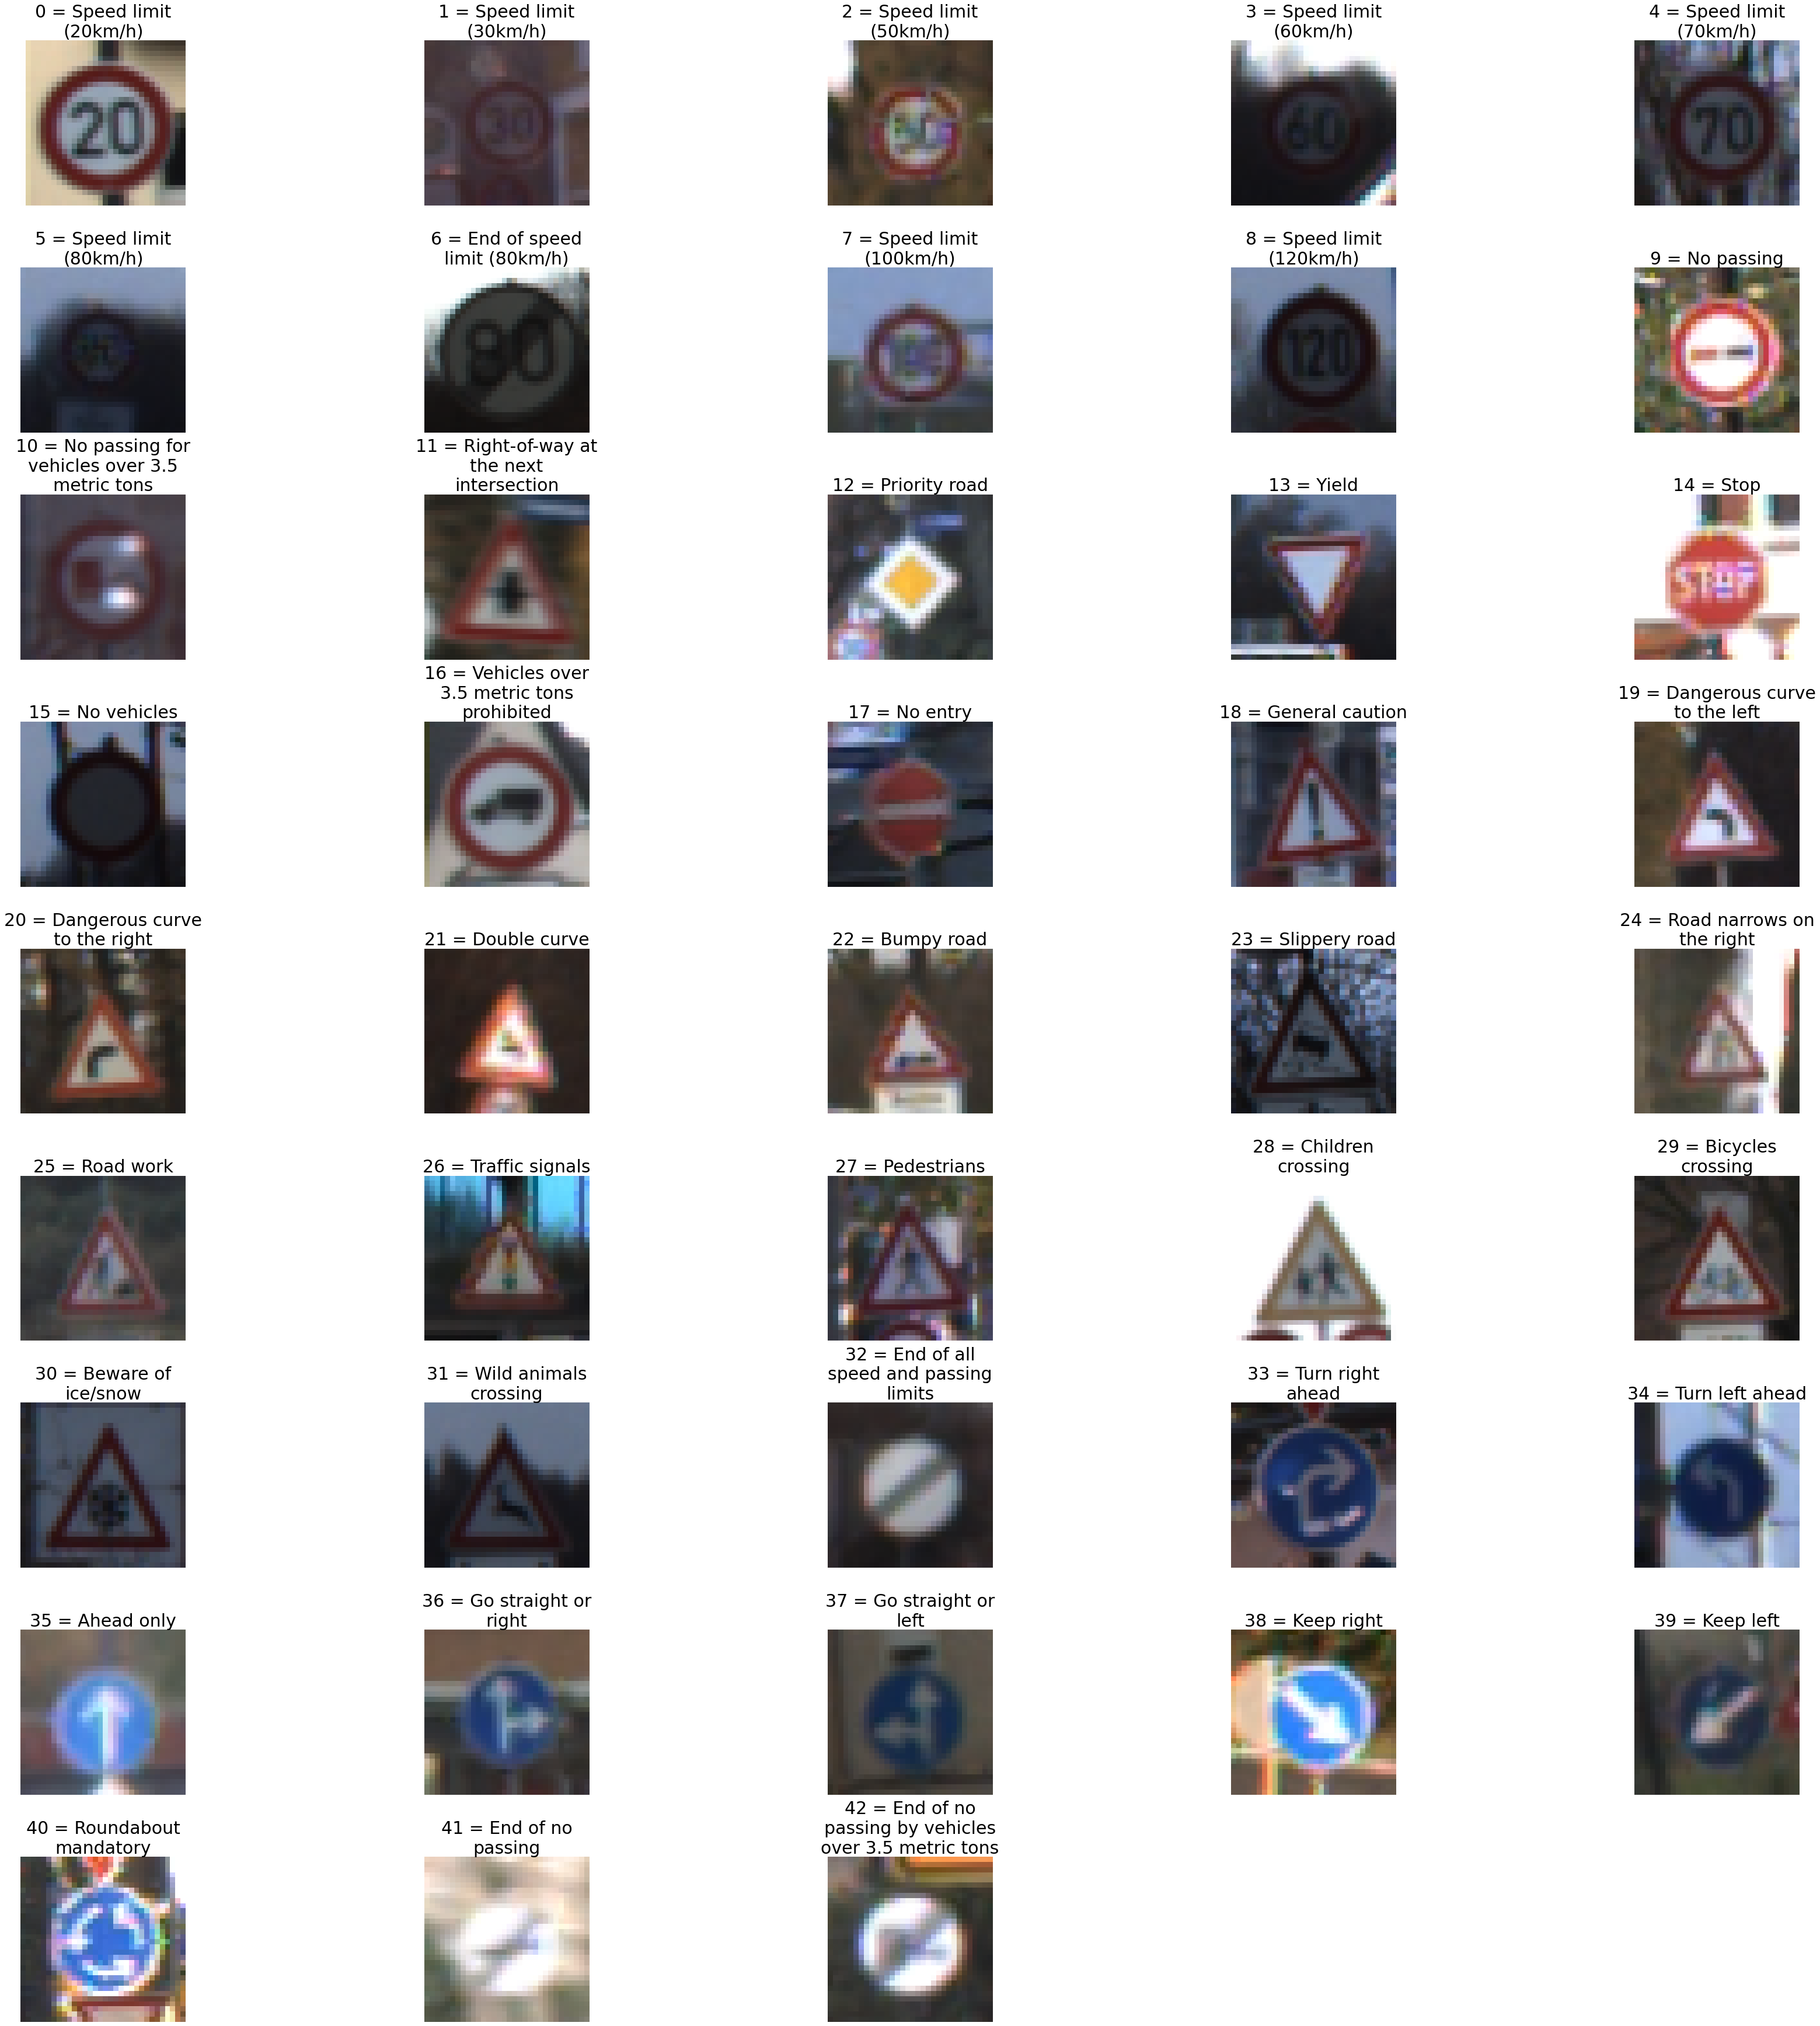

In [7]:
# plot an example of each sign type
rows = 9
cols = 5

plt.figure(1, figsize=(48,48))
for i in range(43):
    plt.subplot(rows, cols, i+1)
    plt.title("\n".join(wrap('{0} = {1}'.format(i, sign_name_dict[str(i)]), 20)), fontsize=30)
    plt.imshow(sign_examples[i])
    plt.axis('off')

plt.savefig('images_output/sign_class.png', dpi=300, bbox_inches='tight')
plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

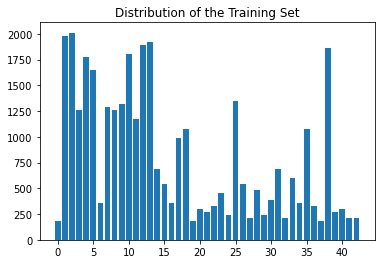

In [8]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
plt.bar(range(n_classes), [len(s) for s in signs_by_id_train], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Training Set')

plt.savefig('images_output/Distribution_of_the_Training_Set.png', dpi=300, bbox_inches='tight')

plt.show()


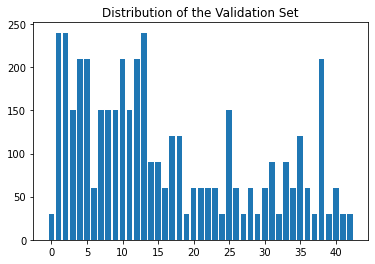

In [9]:
plt.bar(range(n_classes), [len(s) for s in signs_by_id_valid], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Validation Set')

plt.savefig('images_output/Distribution_of_the_Validation_Set.png', dpi=300, bbox_inches='tight')

plt.show()

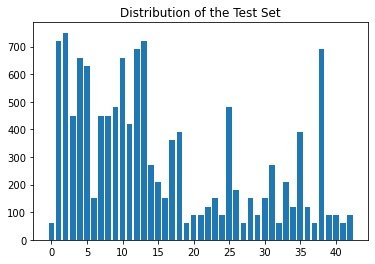

In [10]:
plt.bar(range(n_classes), [len(s) for s in signs_by_id_test], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Test Set')

plt.savefig('images_output/Distribution_of_the_Test_Set.png', dpi=300, bbox_inches='tight')

plt.show()

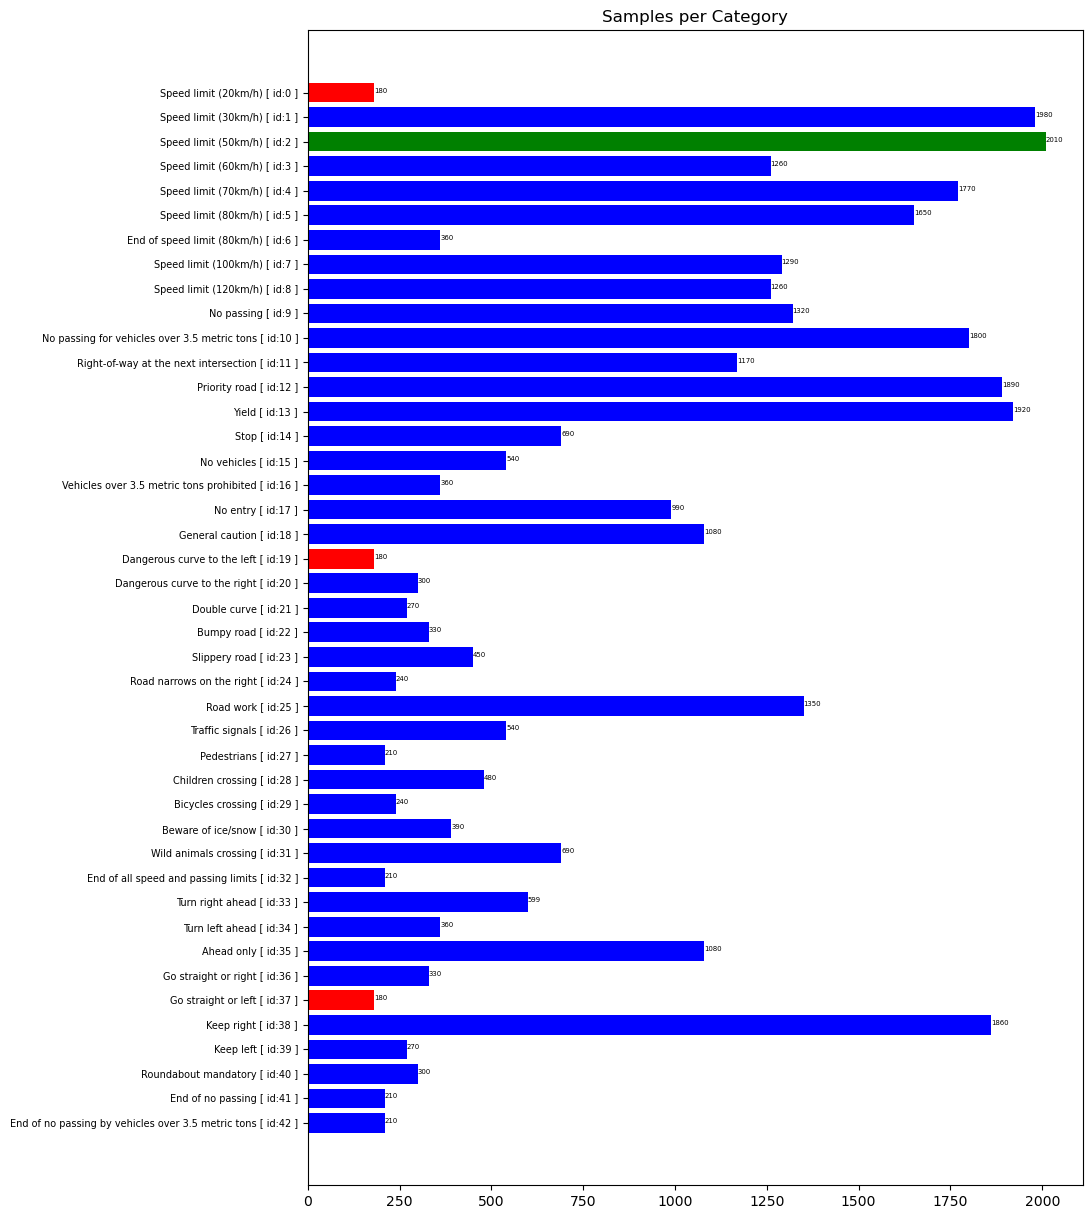

In [12]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Sign id<->name mapping
sign_names = pd.read_csv('signnames.csv').to_dict(orient='index')
sign_names = { key : val['SignName'] for key, val in sign_names.items() }


plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 15))

samples_per_category = [len(np.where(y_train==cat_id)[0]) for cat_id in sign_names.keys()]
category_names = tuple([val + " [ id:{id} ]".format(id=key) for key,val in sign_names.items()])

min_cnt = min(samples_per_category)
max_cnt = max(samples_per_category)

y_pos = np.arange(len(category_names))

rects = ax.barh(y_pos, 
                samples_per_category, 
                align='center', 
                color=['blue' if val != min_cnt and val != max_cnt \
                       else 'red' if val == min_cnt \
                       else 'green' for val in samples_per_category])

# setting labels for each bar
for i in range(0,len(rects)):
    ax.text(int(rects[i].get_width()), 
            int(rects[i].get_y()+rects[i].get_height()/2.0),
            samples_per_category[i],
            fontproperties=fm.FontProperties(size=5))

ax.set_yticks(y_pos)
ax.set_yticklabels(category_names,fontproperties=fm.FontProperties(size=7))
ax.invert_yaxis()
ax.set_title('Samples per Category')

plt.savefig('images_output/bar_per_Category.png', dpi=300, bbox_inches='tight')

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def preprocess(img):
    
    return (img - 128.) / 128.

In [14]:
X_train = np.array([preprocess(img) for img in X_train])
X_valid = np.array([preprocess(img) for img in X_valid])
X_test = np.array([preprocess(img) for img in X_test])

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [15]:
def forward_pass(x):
    
    # Arguments used for tf.truncated_normal --> used to randomly define the weights and biases
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    w1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    h1 = tf.nn.conv2d(x, w1, strides, padding) + b1

    # Activation.
    a1 = tf.nn.dropout(tf.nn.relu(h1), keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'SAME'
    a2 = tf.nn.dropout(tf.nn.max_pool(a1, ksize, strides, padding), keep_prob)
    

    # Layer 2: Convolutional. Output = 10x10x16.
    w3 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(16))
    strides = [1, 1, 1, 1]
    padding = 'VALID'
    h3 = tf.nn.conv2d(a2, w3, strides, padding) + b3

    # Activation.
    a3 = tf.nn.dropout(tf.nn.relu(h3), keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    padding = 'SAME'
    a4 = tf.nn.dropout(tf.nn.max_pool(a3, ksize, strides, padding), keep_prob)

    # Flatten. Input = 5x5x16. Output = 400.
    a5 = flatten(a4)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w6 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    b6 = tf.Variable(tf.zeros(120))
    h6 = tf.add(tf.matmul(a5, w6), b6)

    # Activation.
    a6 = tf.nn.dropout(tf.nn.relu(h6), keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w7 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b7 = tf.Variable(tf.zeros(84))
    h7 = tf.add(tf.matmul(a6, w7), b7)

    # Activation.
    a7 = tf.nn.dropout(tf.nn.relu(h7), keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w8 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b8 = tf.Variable(tf.zeros(43))

    return tf.add(tf.matmul(a7, w8), b8)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [16]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

In [17]:
# hyperparameters of the training process
EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001

In [18]:

logits = forward_pass(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [20]:
def evaluate(X_data, y_data):
    
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './traffic-signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.739

EPOCH 2 ...
Validation Accuracy = 0.853

EPOCH 3 ...
Validation Accuracy = 0.890

EPOCH 4 ...
Validation Accuracy = 0.905

EPOCH 5 ...
Validation Accuracy = 0.919

EPOCH 6 ...
Validation Accuracy = 0.932

EPOCH 7 ...
Validation Accuracy = 0.934

EPOCH 8 ...
Validation Accuracy = 0.941

EPOCH 9 ...
Validation Accuracy = 0.946

EPOCH 10 ...
Validation Accuracy = 0.943

EPOCH 11 ...
Validation Accuracy = 0.929

EPOCH 12 ...
Validation Accuracy = 0.945

EPOCH 13 ...
Validation Accuracy = 0.943

EPOCH 14 ...
Validation Accuracy = 0.948

EPOCH 15 ...
Validation Accuracy = 0.952

EPOCH 16 ...
Validation Accuracy = 0.948

EPOCH 17 ...
Validation Accuracy = 0.953

EPOCH 18 ...
Validation Accuracy = 0.954

EPOCH 19 ...
Validation Accuracy = 0.954

EPOCH 20 ...
Validation Accuracy = 0.946

EPOCH 21 ...
Validation Accuracy = 0.947

EPOCH 22 ...
Validation Accuracy = 0.954

EPOCH 23 ...
Validation Accuracy = 0.951

EPOCH 24 ...
Validation Accura

### Evaluate Trained Model Using Test Samples

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("\n  Training set accuracy = {:.3f}".format(evaluate(X_train, y_train)))
    print("Validation set accuracy = {:.3f}".format(evaluate(X_valid, y_valid)))
    print("      Test set accuracy = {:.3f}".format(evaluate(X_test, y_test)))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\traffic-signs

  Training set accuracy = 1.000
Validation set accuracy = 0.950
      Test set accuracy = 0.943


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

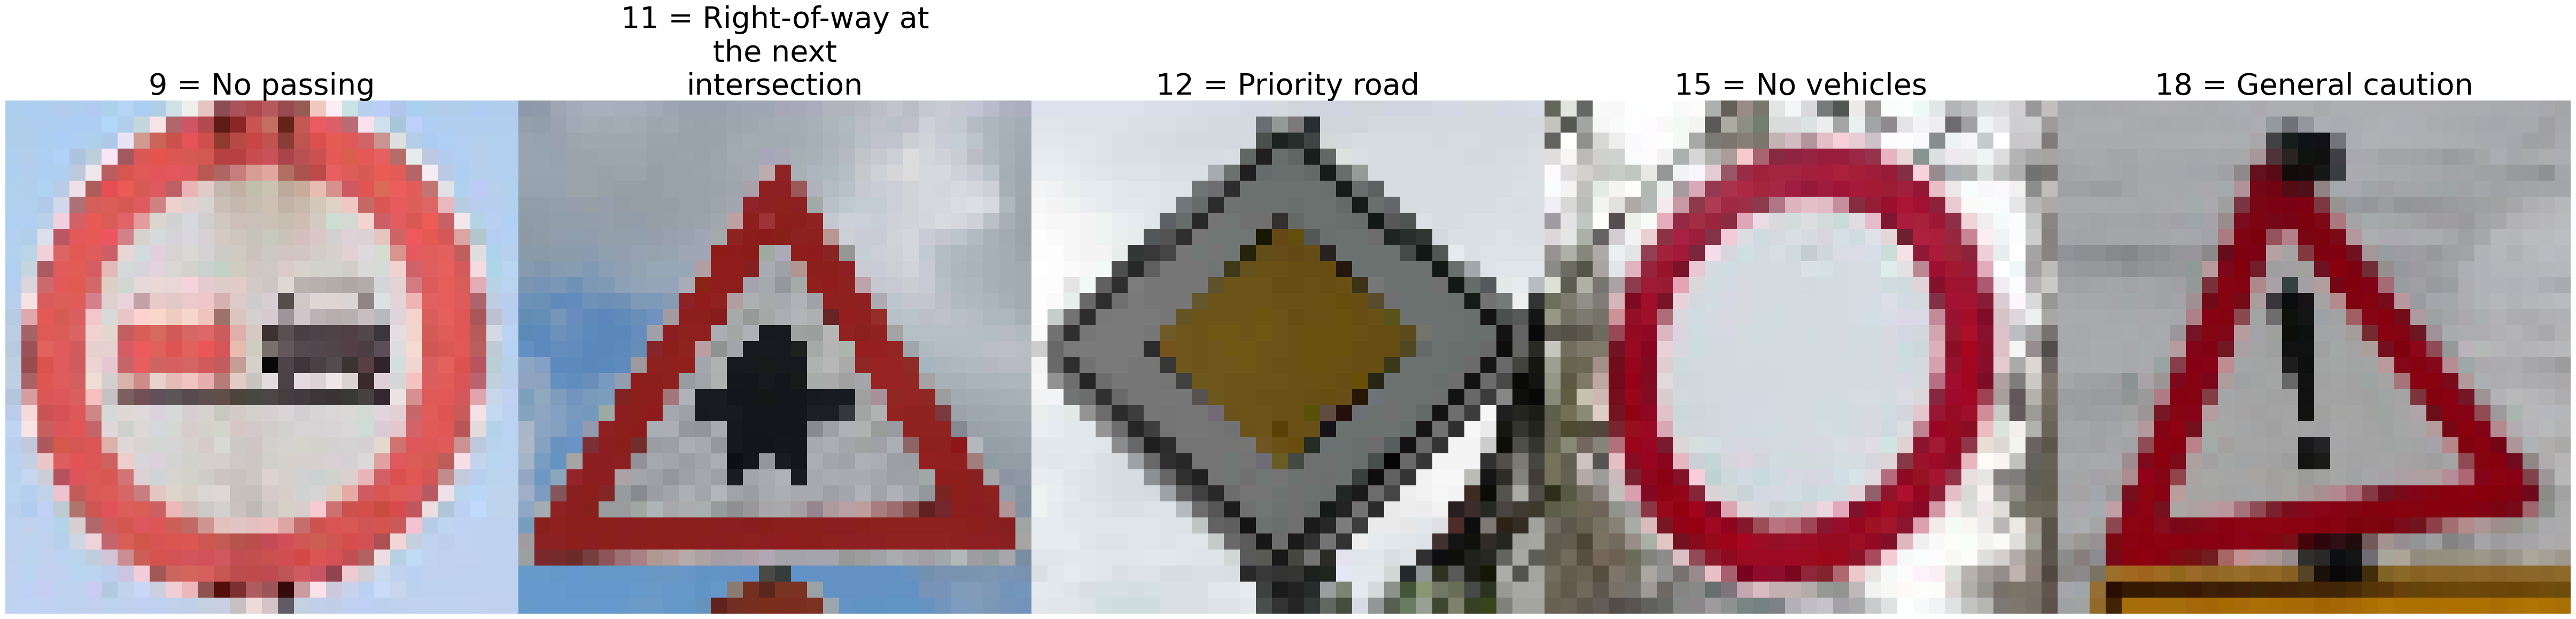

In [28]:
test_image_dir = 'test_images/'

# sort the images by their type
test_images = sorted(os.listdir(test_image_dir), key=lambda img: int(img.split('_')[0]))

# extract the image types from their filenames
y_new = np.array([int(img.split('_')[0]) for img in test_images])

# load the images
X_new0 = np.array([cv2.resize(plt.imread(test_image_dir + img), (32, 32)) for img in test_images])

# pre-process the images
X_new = np.array([preprocess(img) for img in X_new0])

# plot the images
plt.figure(1, figsize=(48,48))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title("\n".join(wrap('{0} = {1}'.format(y_new[i], sign_name_dict[str(y_new[i])]), 20)), fontsize=40)
    plt.imshow(X_new0[i, :, :, :])
    plt.axis('off')
    
plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [29]:
# preprocess images first
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: X_new, keep_prob: 1.0})
    
print('\nPrediction   Actual')
print('----------   ------------')    
for p_i, y_i in zip(predictions, y_new):
    print('    {0:2d}            {1:2d}     '.format(p_i, y_i))
    
    


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\traffic-signs

Prediction   Actual
----------   ------------
     9             9     
    11            11     
    12            12     
    15            15     
    18            18     


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [32]:
# run evaluation on the new images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    new_accuracy = evaluate(X_new, y_new)
    print("\nNew Accuracy = {:.3f}".format(new_accuracy))

INFO:tensorflow:Restoring parameters from .\traffic-signs

New Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [35]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    softmaxes = sess.run(tf.nn.softmax(logits), feed_dict={x: X_new, keep_prob: 1.0})
    
    values, indices = sess.run(tf.nn.top_k(softmaxes, k=5))
    
np.set_printoptions(precision=5)
print('\n' + str(values))

INFO:tensorflow:Restoring parameters from .\traffic-signs

[[9.99678e-01 2.34781e-04 5.10068e-05 3.36650e-05 1.68965e-06]
 [1.00000e+00 9.68198e-10 2.86479e-13 9.05648e-14 1.98021e-14]
 [1.00000e+00 3.64810e-13 1.13829e-13 5.35891e-14 1.63327e-14]
 [1.00000e+00 4.50395e-10 2.35637e-10 8.02557e-11 4.41918e-11]
 [1.00000e+00 1.10821e-11 4.82266e-12 2.68410e-16 1.40032e-18]]


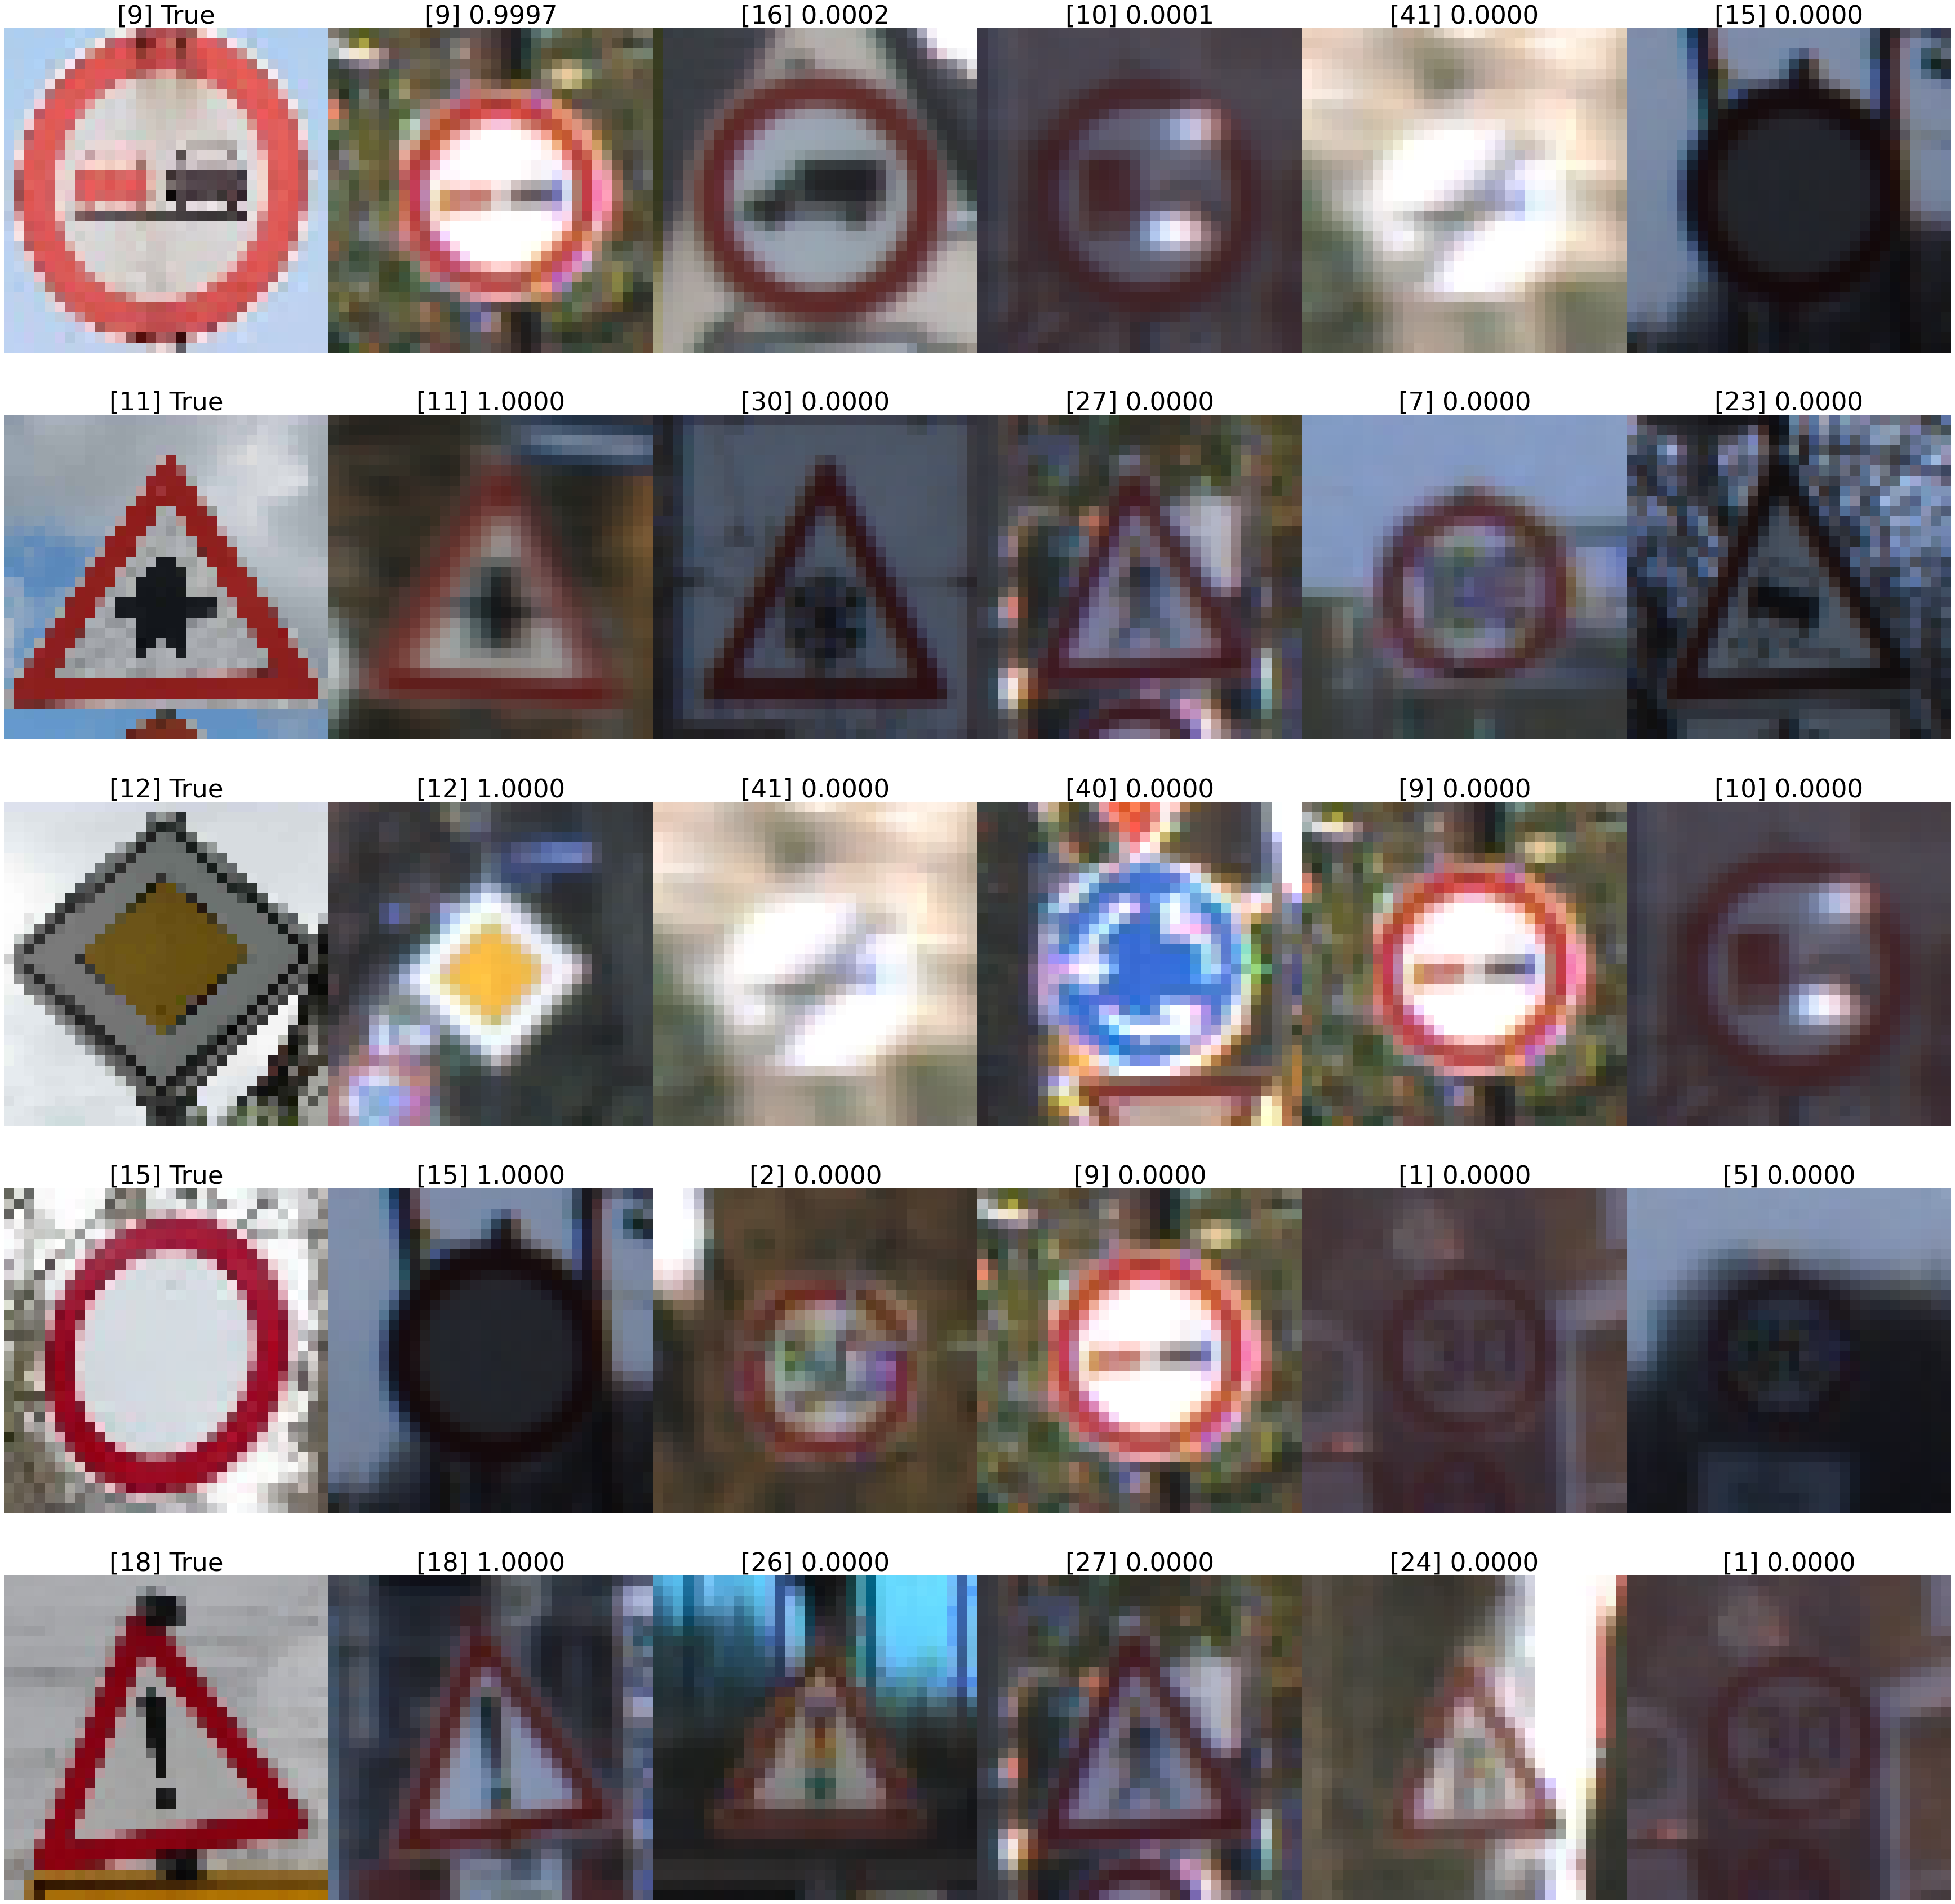

In [38]:
# Print out the top five softmax probabilities for the predictions on 
# the German traffic sign images found on the web. 
rows, cols = values.shape
cols += 1

plt.figure(1, figsize=(48,48))
for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, row*cols + col + 1)
        if col == 0:
            plt.title("[{0}] True".format(y_new[row]), fontsize=45)
            plt.imshow(X_new0[row, :, :, :])
        else:
            plt.title("[{0}] {1:.4f}".format(indices[row, col-1], values[row, col-1]), fontsize=45)  
            plt.imshow(sign_examples[indices[row, col-1]])
            
        plt.axis('off')
    
plt.savefig('images_output/five_softmax_probabilities.png', dpi=300, bbox_inches='tight')
   

plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)




### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# **Traffic Sign Recognition** 

## Writeup

### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Build a Traffic Sign Recognition Project**

The goals / steps of this project are the following:
* Load the data set (see below for links to the project data set)
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report


[//]: # (Image References)

[image1]: ./images_output/bar_per_Category.png "Visualization"
[image2]: ./examples/grayscale.jpg "Grayscaling"
[image3]: ./examples/random_noise.jpg "Random Noise"
[image4]: ./test_images/image1.png "Traffic Sign 1"
[image5]: ./test_images/image2.png "Traffic Sign 2"
[image6]: ./test_images/image3.png "Traffic Sign 3"
[image7]: ./test_images/image4.png "Traffic Sign 4"
[image8]: ./test_images/image5.png "Traffic Sign 5"
[image9]: ./images_output/lenet.png "network architecture"
[image10]: ./test_images/image6.png "Traffic Sign 6"

## Rubric Points
### Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/481/view) individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. You can use this template as a guide for writing the report. The submission includes the project code.

You're reading it! and here is a link to my [project code](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb)

### Data Set Summary & Exploration

#### 1. Provide a basic summary of the data set. In the code, the analysis should be done using python, numpy and/or pandas methods rather than hardcoding results manually.

I used the pandas library to calculate summary statistics of the traffic
signs data set:

* The size of training set is **34799**
* The size of the validation set is **4410**
* The size of test set is **12630**
* The shape of a traffic sign image is **(32, 32, 3)**
* The number of unique classes/labels in the data set is **43** 

#### 2. Include an exploratory visualization of the dataset.

Here's an exploratory visualization of the dataset. A bar graph where the y-axis is located vertically on the left side has 43 signs and traffic classes. On the other hand, we have the x-axis horizontal that describes each class's number of traffic signs (0 - 2000).

The bar graph shows the distribution of the classification of traffic signs. The color blue long bars indicate the classes that stand out the most from those between 1750 and 2000. For example, let's look at the axis, and the class of "Speed limit ( 80km / h) "and End of no pass" are the classes with the highest number of signals, very close to 2000 according to the graph.

Now let's see the classification with the color red shortest bars and that they are around the value of 250. For example, we have the class "Speed limit (20km / h)" and "Speed limit (120km / h). They are above that number.

The graph shows us a visual way to identify how our dataset is distributed quickly.


![alt text][image1]

### Design and Test a Model Architecture

#### 1. Describe how you preprocessed the image data. What techniques were chosen and why did you choose these techniques? Consider including images showing the output of each preprocessing technique. Pre-processing refers to techniques such as converting to grayscale, normalization, etc. (OPTIONAL: As described in the "Stand Out Suggestions" part of the rubric, if you generated additional data for training, describe why you decided to generate additional data, how you generated the data, and provide example images of the additional data. Then describe the characteristics of the augmented training set like number of images in the set, number of images for each class, etc.)

It is necessary to perform some transformations on each image to feed it to the neural network.

The pre-processing was for each of the 3 color channels (RGB); for image data, (pixel - 128)/ 128 is used a quick way to approximately normalize the data and can be used for this project


Normalize the RGB image. It is done to make each image "look similar" to each other so that the input is consistent.
Convert RGB image to grayscale. The neural network is believed to perform slightly better on grayscale images. However, they can also be incorrect observations.
An attempt was also made to use adaptive histogram equalization to improve local contrast and improve edge definitions in each image region. Still, it decreased network performance, So it is the only normalization and grayscale conversion used in the final implementation.


Here is an example of a traffic sign image before and after grayscaling.

![alt text][image2]


The training set expanded with more data. The intention was to equalize the sample count in each category, the categories containing a smaller number of samples expanded with more duplicate images. The odds of getting images for each category during training became equal. Dramatically improved neural network performance. 


#### 2. Describe what your final model architecture looks like including model type, layers, layer sizes, connectivity, etc.) Consider including a diagram and/or table describing the final model.

My final model is based off LeNet consisted of the following layers:

##### Architecture

| Layer           |     Description 	                              | 
|:----------------|:--------------------------------------------------| 
| Input           | 32x32x3 RGB image                                 |
| Convolution 5x5 | 1x1 stride, `VALID` padding, outputs 28x28x6      |
| ReLU            |                                                   |
| Max pooling     | k=2, 2x2 stride, `SAME` padding, outputs 14x14x16 |
| ReLU            |                                                   |
| Convolution 5x5 | 1x1 stride, `VALID` padding, outputs 10x10x16     |
| ReLU            |                                                   |
| Max pooling     | k=2, 2x2 stride, `SAME` padding, outputs 5x5x16   |
| Flatten   	  | outputs 400                                       |
| Fully connected | outputs 120                                       |
| ReLU            |                                                   |
| Fully connected | outputs 84                                        |
| ReLU            |                                                   |
| Fully connected | outputs 43                                        |
 




#### 3. Describe how you trained your model. The discussion can include the type of optimizer, the batch size, number of epochs and any hyperparameters such as learning rate.

50 epochs were used to train the model. Initially, 10 was used; however, discovered that more epochs were needed to achieve greater precision. Also tested it 100 epochs, deduced that it did not improve over 50 epochs.

The same optimizer, tf.train.AdamOptimizer was used as in the LeNet lab.

I used rate = 0.001 for the learning rate; I tried using rate = 0.0001; however, the results weren't that good.

For attrition, keep_prob = 0.9 was used when training, found to offer better results than keep_prob = 0.5



#### 4. Describe the approach taken for finding a solution and getting the validation set accuracy to be at least 0.93. Include in the discussion the results on the training, validation and test sets and where in the code these were calculated. Your approach may have been an iterative process, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think the architecture is suitable for the current problem.

A LeNet model was used where it was modified to accept inputs with a depth of 3 (32x32x3) instead of 1 (32x32x1), as we are working with RGB images and not grayscale images.
Changed the length of the output to 43 (the number of classifications), not 10 (the number of digits). Also introduced dropout into the model to achieve greater precision. 

LeNet model presented in his 1998 research paper using TensorFlow. The algorithm architecture consists of 2 convolution layers followed by three fully connected layers. Convolution layers handle the extraction of features from traffic sign images, which help learn to recognize them. Each convolution layer has followed by relu activation and maximum grouping to filter images down to the pixels that matter. After the last convolution layer, the flatten operation has applied to transform the output shape to a vector. The first two fully connected layers had followed by reluctance and dropout to prevent the model from overfitting the data. Finally, the fully connected layers reduce the output vector to 43 different classes so that the model can predict the type of road sign in the image. Can find the code implementation for the modified LeNet architecture function in the Jupyter notebook. 

The final model results were:

* training set accuracy of 100.0%
* validation set accuracy of 95.6%
* test set accuracy of 94.8%

### Test a Model on New Images

#### 1. Choose five German traffic signs found on the web and provide them in the report. For each image, discuss what quality or qualities might be difficult to classify.

The algorithm design aims to improve the identification of traffic signs found on the streets and highways through the rapid acquisition and interpretation of the images. However, several non-technical external challenges that this system can face in the real world, degrading its performance significantly. Among these challenges are; Variable lighting conditions and fading and blurring effects caused by lighting through rain or snow.

Here are five German traffic signs that I found on the web:

<img src="./test_images/9_no_passing.jpg " alt="data_augumentation" width="200"/>

<img src="./test_images/11_right-of-way.jpg " alt="data_augumentation" width="200"/>

<img src="./test_images/12_priority_road.jpg " alt="data_augumentation" width="200"/>

<img src="./test_images/15_no_vehicles.jpg " alt="data_augumentation" width="200"/>

<img src="./test_images/18_general_caution.jpg " alt="data_augumentation" width="200"/>



The second and third images could represent difficulties to classify due to low light and show additional features of shapes in the background that the algorithm misinterpreted.


#### 2. Discuss the model's predictions on these new traffic signs and compare the results to predicting on the test set. At a minimum, discuss what the predictions were, the accuracy on these new predictions, and compare the accuracy to the accuracy on the test set (OPTIONAL: Discuss the results in more detail as described in the "Stand Out Suggestions" part of the rubric).

Here are the results of the prediction:

| Image                                      | Prediction                                 |
|:-------------------------------------------|:-------------------------------------------| 
| (9) No passing                             | (9) No passing                             | 
| (11) Right-of-way at the next intersection | (11) Right-of-way at the next intersection | 
| (12) Priority road                         | (12) Priority road                         |
| (15) No vehicles                           | (15) No vehicles                           |
| (18) General caution                       | (18) General caution                       |



The model was able to correctly predicted 5 of the 5 road signs, giving an accuracy of 94.8%. However, on occasions, it does not show the same precision. It is to say that when the algorithm is run, there are times that it only asserts 4 out of 5.

#### 3. Describe how certain the model is when predicting on each of the five new images by looking at the softmax probabilities for each prediction. Provide the top 5 softmax probabilities for each image along with the sign type of each probability. (OPTIONAL: as described in the "Stand Out Suggestions" part of the rubric, visualizations can also be provided such as bar charts)

The code for making predictions on my final model is located in the 11th cell of the Ipython notebook.

For the first image, the model is relatively sure that this is a stop sign (probability of 0.6), and the image does contain a stop sign. The top five soft max probabilities were

| Probability         	|     Prediction	        					| 
|:---------------------:|:---------------------------------------------:| 
| 9.99678e-01         			| No passing   									| 
| 1.00000e+00     				| Right-of-way at the next 										|
| 
1.00000e+00					| Priority road											|
| 1.00000e+00	      			| No vehicles					 				|
| 1.00000e+00				    | General caution      							|


![test_set_distribution.png](images_output/five_softmax_probabilities.png)

### (Optional) Visualizing the Neural Network (See Step 4 of the Ipython notebook for more details)
#### 1. Discuss the visual output of your trained network's feature maps. What characteristics did the neural network use to make classifications?


